In [28]:
import os
import sys
sys.path.append('../')

from collections import Counter

import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import umap
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor

from utils.main import read_py

In [2]:
SUBMISSION_FILE = '../submissions/multiclass_standard_2_1_0_noleak_thresh10.csv'
assert os.path.exists(SUBMISSION_FILE)

MODEL_CONFIG_PATH = '../train_configs/multiclass_standard.py'
assert os.path.exists(MODEL_CONFIG_PATH)

MODEL_CHECKPOINT_PATH = '../checkpoints/multiclass_standard_2_1_resnet50_bs64_100epochs_cosinelr/epoch=25-step=1404.ckpt'
assert os.path.exists(MODEL_CHECKPOINT_PATH)

TRAIN_FILE = '../data/train.csv'
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test/'

In [3]:
sub_df = pd.read_csv(SUBMISSION_FILE)
train_df = pd.read_csv(TRAIN_FILE)

In [8]:
all_classes = list(sub_df['class'].apply(lambda x: x.split(' ')).values)

In [10]:
all_classes = [item for sublist in all_classes for item in sublist]

In [16]:
classes_counts = Counter(all_classes)

In [20]:
top_classes = classes_counts.most_common(20)

In [56]:
ranking = {pair[0]: rank 
           for rank, pair in enumerate(classes_counts.most_common())}

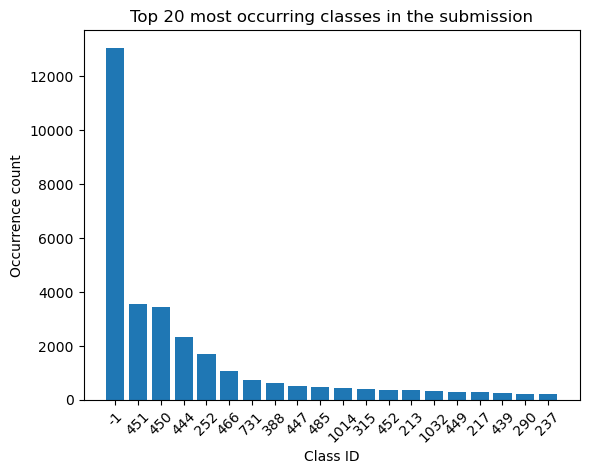

In [22]:
plt.bar([counts[0] for counts in top_classes], [counts[1] for counts in top_classes])
plt.title('Top 20 most occurring classes in the submission')
plt.xlabel('Class ID')
plt.ylabel('Occurrence count')
plt.xticks(rotation=45)
plt.show()

In [28]:
classes_samples = train_df.groupby('class').sample(1).reset_index()
top_classes_samples = classes_samples[classes_samples['class'].isin([int(counts[0]) for counts in top_classes])].copy()
top_classes_samples['class_count'] = top_classes_samples['class'].apply(lambda x: classes_counts[str(x)])

In [37]:
top_classes_samples = top_classes_samples.sort_values('class_count', ascending=False)

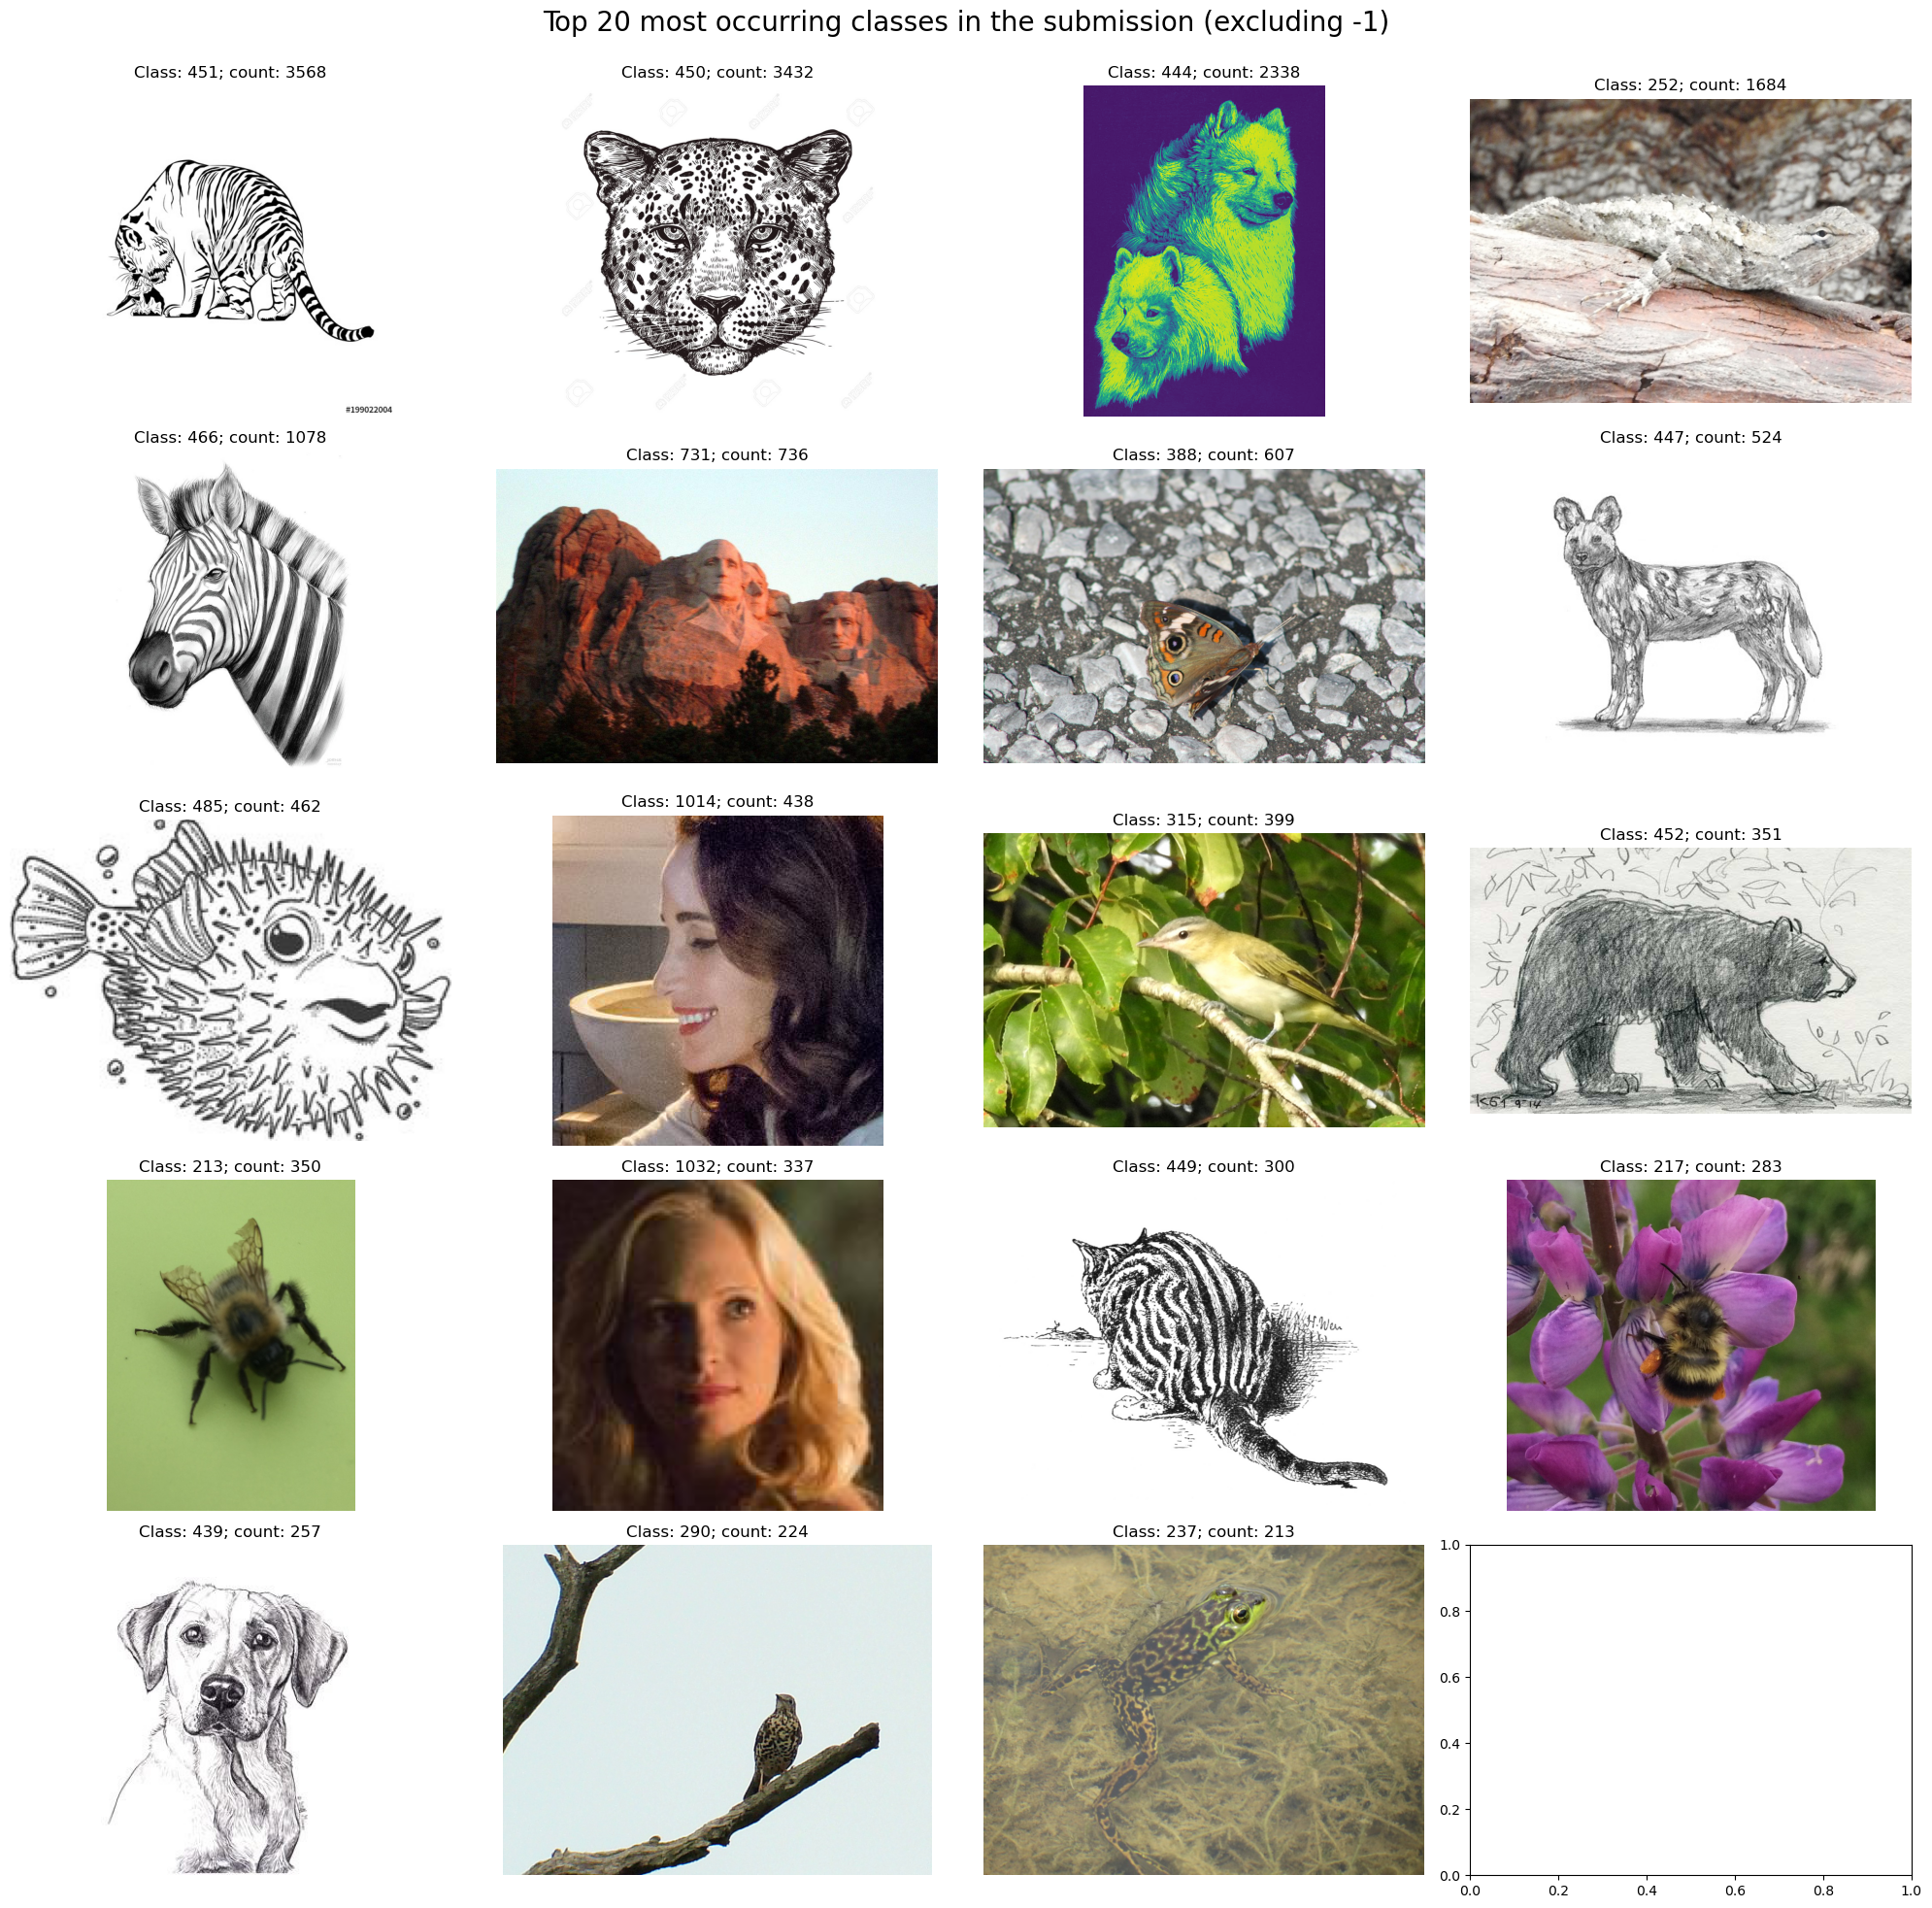

In [43]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
for i, (_, row) in enumerate(top_classes_samples.iterrows()):
    row_num = i//4
    col_num = i%4

    img = plt.imread(os.path.join(TRAIN_DIR, f"{row['file_id']}.jpg"))
    axs[row_num, col_num].imshow(img)
    axs[row_num, col_num].set_title(f'Class: {row["class"]}; count: {row["class_count"]}')
    axs[row_num, col_num].axis('off')

plt.suptitle('Top 20 most occurring classes in the submission (excluding -1)', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [58]:
sub_df['class_list'] = sub_df['class'].apply(lambda x: x.split(' '))
sub_df['class_ranks_sum'] = sub_df['class_list'].apply(lambda x: sum([ranking[y] for y in x]))

In [60]:
submission_df_mostcommmon = sub_df.sort_values('class_ranks_sum', ascending=True)

In [62]:
submission_df_mostcommmon = submission_df_mostcommmon.iloc[:10]

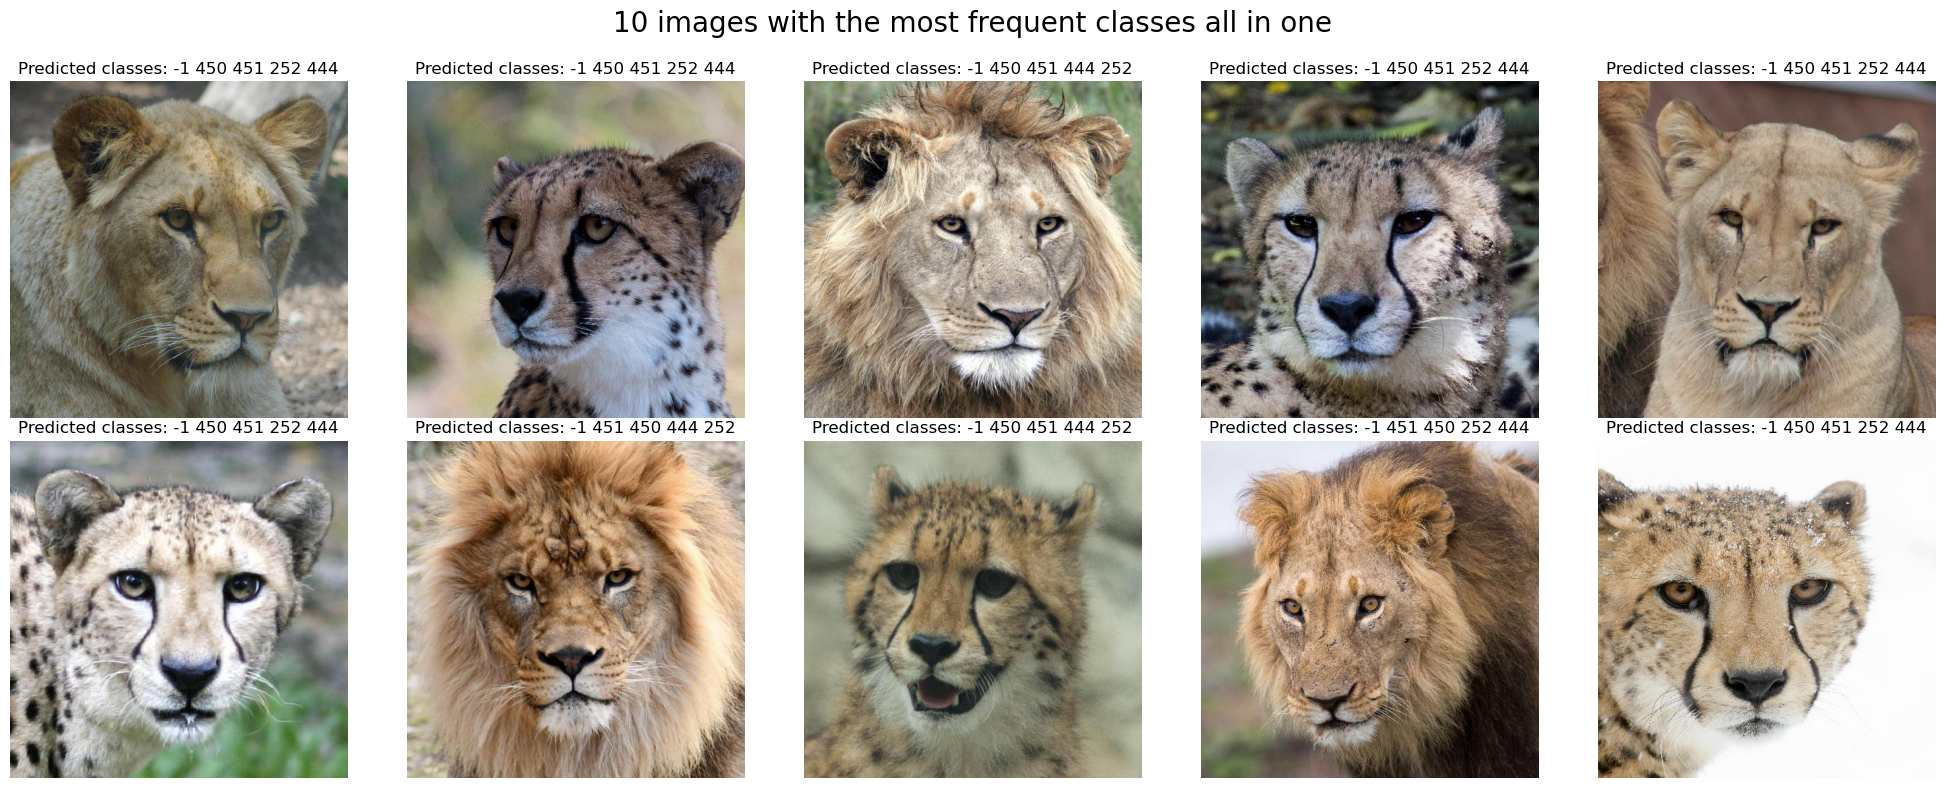

In [66]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, (_, row) in enumerate(submission_df_mostcommmon.iterrows()):
    row_num = i//5
    col_num = i%5

    img = plt.imread(os.path.join(TEST_DIR, f"{row['file_id']}.jpg"))
    axs[row_num, col_num].imshow(img)
    axs[row_num, col_num].set_title(f'Predicted classes: {row["class"]}')
    axs[row_num, col_num].axis('off')

plt.suptitle('10 images with the most frequent classes all in one', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [4]:
CONFIG = read_py(MODEL_CONFIG_PATH).CONFIG

c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = CONFIG['model'](**CONFIG['model_params'])
forward = CONFIG['forward'](model, **CONFIG['forward_params'])
forward.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['state_dict'])

C:\Users\Andrii\AppData\Local\Temp\ipykernel_1880\1169275805.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forward.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH)['s

<All keys matched successfully>

In [67]:
def obtain_embedding(img_path):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)

    return forward(img, return_embedding=True).detach().numpy()[0]

In [18]:
train_df['embedding'] = train_df['file_id'].apply(lambda x: obtain_embedding(os.path.join(TRAIN_DIR, f"{x}.jpg")))

In [29]:
reducer = umap.UMAP()

In [42]:
final_embeddigs = reducer.fit_transform(np.stack(train_df['embedding'].values))

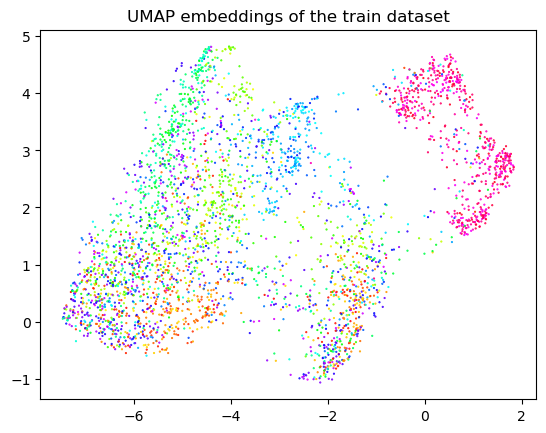

In [49]:
plt.scatter(final_embeddigs[:, 0], final_embeddigs[:, 1], c=train_df['class'], s=0.3, cmap='hsv')
plt.title('UMAP embeddings of the train dataset')
plt.show()

In [54]:
random_classes = np.random.choice(train_df['class'].unique(), 20)

In [55]:
train_df['viz_embeddings'] = final_embeddigs.tolist()

In [57]:
random_classes_samples = train_df[train_df['class'].isin(random_classes)].copy()

In [58]:
random_classes_samples

class                           file_id  \
12      725  f4c259e8dbeb6fa212f7ef7254b4c081   
101       8  0c1ef197775c96a53fcafbd6b9902726   
157     872  b9da1a248608ff36bc8eb1b1d65603db   
182     260  ac82e6acb00d1b4638c46d47c5f60c74   
271     187  8006d3b22284572a0fd3b81cd3eff46b   
318     260  8972431f626b9cd36107db2c4eec7850   
323     186  cd13a2ef6403d61bcfa24c0755b68835   
388      85  5316893e429e15dfbed94a27fd3f4b3b   
435     607  931315dcafcffb1a2d2e5877774a6e17   
441      85  98e0e018431ba7ba52f36fa33419ebfc   
442     200  4fc88a9566c3ce6127a8e3ec95dca192   
469    1062  e2660ea166a16923d23990f27fc84600   
580     858  0cb7f402b15489cc05e99b325fe5b7b2   
619     880  b145845c667d28a371e9e595ce472cae   
681     260  12af12eaa98d99515abbfdf67dfbee2a   
782     538  0a58f869db9e1ffef6aa1eae468e068f   
798     187  c2243a3ae9ce6f5967da14bf9744d278   
852     538  89ca2d0b5ef6608f1a74fed26b893aed   
882     880  589260a78e03c87c1c9d5bf1f7dab59c   
1043    187  c527ed536bea95c7b0ec365a94ef0171   
1121    544  7e530d5a378a965170325a173b4a3750   
1175    841  ca4dde2d9ef728b8c3300669c5330e7c   
1202    846  8af7926cc672bf86adba2647d3150bfa   
1213     95  651bec5cada37be6a96230ed57bbbdec   
1214    200  d39126de78f274d72ad98224f6ec5ccf   
1366     95  7093ecb61428b38c6bd6fc298cb19910   
1368    841  7a6729b9ef269686a23c63ad32a4d212   
1371   1004  bb19e98efb2281cd645477d690e2b704   
1409    200  7bd863fba0ac37bdeb9615483133bb9a   
1433    544  7fa9098d82134bffc6ec4842d88592a0   
1573    538  da75203af3e5b2a7a67cd239d6555117   
1711   1062  625066b3ef6cec89b1930e3f6e1e4f25   
1790    846  a530b0de44e30f9c431d100cc2819b01   
1798    880  441a075d3136affd54691516a264f87b   
1822    872  f28001dcb6d37ee095cc195a350cef99   
1920    725  9b444cf9389b9c44c571a139a35a70ea   
2018    607  7e15df158975bdcf5d1619af4c43886d   
2140    849  d69135d8c306f649a075162ff43bdeef   
2182   1004  f6322f9f11918df0259a5172394eac71   
2237    849  d0f8021aa7e96a9d02feb293b9948c3b   
2388    841  0968dcdef7af5a9346ad8f18b3f0fecd   
2418   1004  f06e9df814d3b7b9eee3a5a71e710e6f   
2441   1062  ae1743f29f0401d86182f2d5a17762e5   
2491    872  c14a62ccc6617a3e91fde91f8e30eb1f   
2501    858  793fb046887f23952c1753dad31afb9b   
2536     95  b0044604424fbeaa1389f68d860d37fc   
2547      8  3634194994ccc1e57a61aa6ea1f36783   
2559      8  d43009e4b7d8359f25a62d4243093538   
2677    544  a35d3d38d6e82f6b5882b01896b688f3   
2697    636  0d1f17eff24860fc3ac1ce183ae194ac   
2757    636  fb3a9ded7c09889e7b38c3606497ccdd   
2786    186  9550a9b44b18080d847a7895cafa2061   
2820    186  5ee08df4ae3f05d565b62d553e3f00a9   
2869    607  a225ddccfcf627018ba47b0f03ac2be0   
2882     85  e8c37ce56a359469f63543ac9d143abb   
2887    846  bd629011df95ec03227c6d0cde0e3c81   
3127    725  6ce583820ca0539d0d7dcaba608a5b01   
3460    858  053308bd0af73a871ca8e18d2259bae7   
3485    849  d6f743842aa56654917fa2a3a3e2719a   
3510    636  5c6cc6247a0ce6f57416428be494d62c   

                                              embedding  \
12    [0.40646923, 0.09956795, 0.115815915, 0.459995...   
101   [0.475716, 0.10951271, 0.1895031, 0.43489236, ...   
157   [0.2682873, 0.08582308, 0.195895, 0.29997864, ...   
182   [0.39161786, 0.11218243, 0.3044576, 0.5027049,...   
271   [0.22689235, 0.14660986, 0.14284334, 0.3430348...   
318   [0.37413546, 0.10275472, 0.15579231, 0.2167612...   
323   [0.4124921, 0.13944936, 0.06427565, 0.25547647...   
388   [0.4538999, 0.11140562, 0.31149405, 0.3157267,...   
435   [0.46253076, 0.18397184, 0.14539734, 0.1070212...   
441   [0.342996, 0.14809023, 0.17509721, 0.13741991,...   
442   [0.32441586, 0.14377278, 0.16846637, 0.1769736...   
469   [0.38619423, 0.28414264, 0.123263165, 0.368890...   
580   [0.49657443, 0.3149427, 0.2187827, 0.3304502, ...   
619   [0.32432035, 0.36373302, 0.17320444, 0.2183704...   
681   [0.29340485, 0.08252373, 0.16945176, 0.1974332...   
782   [0.24682698, 0.17293079, 0.30891258, 0.2586357...   
798   [0.3038

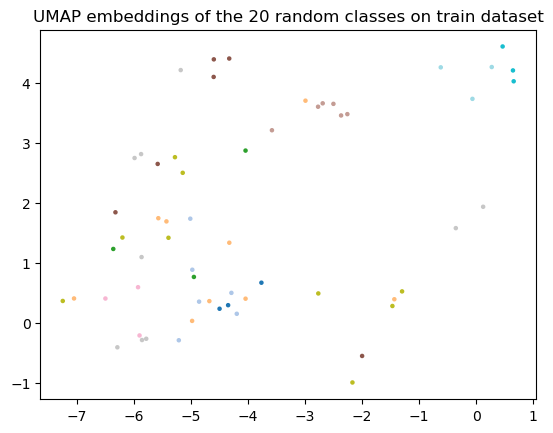

In [65]:
plt.scatter(random_classes_samples['viz_embeddings'].apply(lambda x: x[0]), 
            random_classes_samples['viz_embeddings'].apply(lambda x: x[1]), 
            c=random_classes_samples['class'], 
            s=5, cmap='tab20')
plt.title('UMAP embeddings of the 20 random classes on train dataset')
plt.show()

In [68]:
sub_df['embedding'] = sub_df['file_id'].apply(lambda x: obtain_embedding(os.path.join(TEST_DIR, f"{x}.jpg")))

In [70]:
final_embeddigs_test = reducer.transform(np.stack(sub_df['embedding'].values))

In [71]:
sub_df['viz_embeddings'] = final_embeddigs_test.tolist()

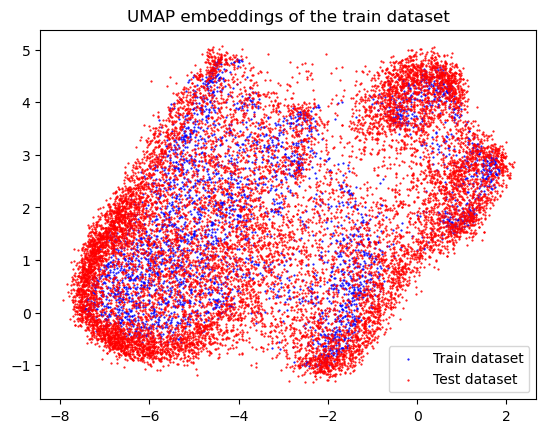

In [72]:
plt.scatter(final_embeddigs[:, 0], final_embeddigs[:, 1], s=0.3, label='Train dataset', c='blue')
plt.scatter(final_embeddigs_test[:, 0], final_embeddigs_test[:, 1], s=0.3, label='Test dataset', c='red')
plt.legend()
plt.title('UMAP embeddings of the train dataset')
plt.show()